# freud.cluster.Cluster and freud.cluster.ClusterProperties

The `freud.cluster` module determines clusters of points and computes cluster quantities like centers of mass, gyration tensors, and radii of gyration. The example below generates random points, and shows that they form clusters. This case is two-dimensional (with $z=0$ for all particles) for simplicity, but the cluster module works for both 2D and 3D simulations.

In [1]:
import freud
import matplotlib.pyplot as plt
import numpy as np

First, we generate a box and random points to cluster.

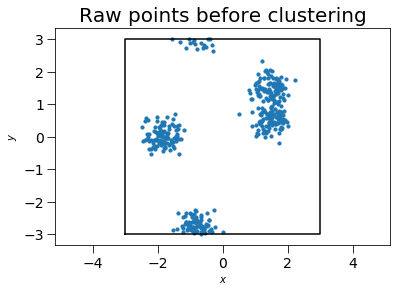

In [2]:
box = freud.Box.square(L=6)
points = np.empty(shape=(0, 2))
for center_point in [(-1.8, 0), (1.5, 1.5), (-0.8, -2.8), (1.5, 0.5)]:
    points = np.concatenate(
        (
            points,
            np.random.multivariate_normal(
                mean=center_point, cov=0.08 * np.eye(2), size=(100,)
            ),
        )
    )
points = np.hstack((points, np.zeros((points.shape[0], 1))))
points = box.wrap(points)
system = freud.AABBQuery(box, points)
system.plot(ax=plt.gca(), s=10)
plt.title("Raw points before clustering", fontsize=20)
plt.gca().tick_params(axis="both", which="both", labelsize=14, size=8)
plt.show()

Now we create a box and a cluster compute object.

In [3]:
cl = freud.cluster.Cluster()

Next, we use the `computeClusters` method to determine clusters and the `clusterIdx` property to return their identities. Note that we use `freud`'s *method chaining* here, where a compute method returns the compute object.

In [4]:
cl.compute(system, neighbors={"r_max": 1.0})
print(cl.cluster_idx)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


There are 200 points in cluster 0.
There are 100 points in cluster 1.
There are 100 points in cluster 2.


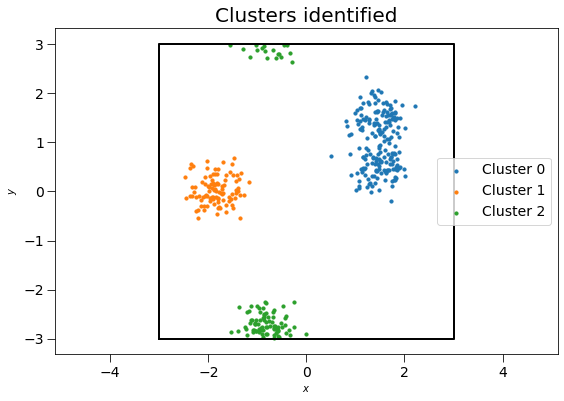

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
for cluster_id in range(cl.num_clusters):
    cluster_system = freud.AABBQuery(
        system.box, system.points[cl.cluster_keys[cluster_id]]
    )
    cluster_system.plot(ax=ax, s=10, label=f"Cluster {cluster_id}")
    print(
        f"There are {len(cl.cluster_keys[cluster_id])} points in cluster {cluster_id}."
    )

ax.set_title("Clusters identified", fontsize=20)
ax.legend(loc="best", fontsize=14)
ax.tick_params(axis="both", which="both", labelsize=14, size=8)
plt.show()

We may also compute the clusters' centers of mass and gyration tensor using the `ClusterProperties` class.

In [6]:
clp = freud.cluster.ClusterProperties()
clp.compute(system, cl.cluster_idx);

Plotting these clusters with their centers of mass, with size proportional to the number of clustered points:

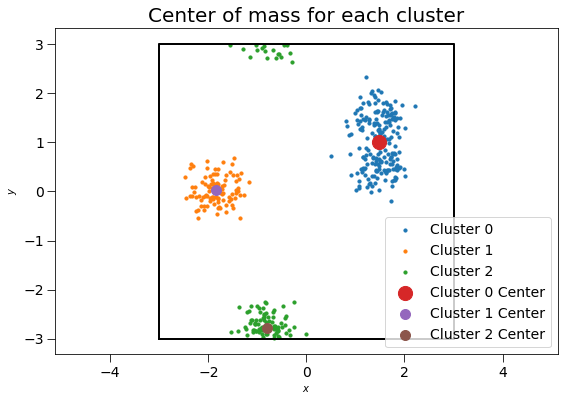

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

for i in range(cl.num_clusters):
    cluster_system = freud.AABBQuery(system.box, system.points[cl.cluster_keys[i]])
    cluster_system.plot(ax=ax, s=10, label=f"Cluster {i}")

for i, c in enumerate(clp.centers):
    ax.scatter(c[0], c[1], s=len(cl.cluster_keys[i]), label=f"Cluster {i} Center")

plt.title("Center of mass for each cluster", fontsize=20)
plt.legend(loc="best", fontsize=14)
plt.gca().tick_params(axis="both", which="both", labelsize=14, size=8)
plt.gca().set_aspect("equal")
plt.show()

The 3x3 gyration tensors $G$ can also be computed for each cluster. For this two-dimensional case, the $z$ components of the gyration tensor are zero. The gyration tensor can be used to determine the principal axes of the cluster and radius of gyration along each principal axis. Here, we plot the gyration tensor's eigenvectors with length corresponding to the square root of the eigenvalues (the singular values).

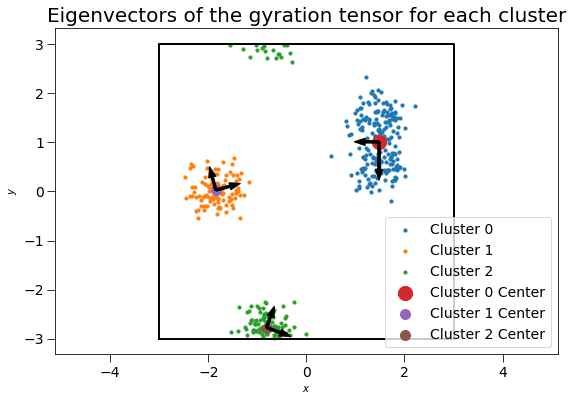

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

for i in range(cl.num_clusters):
    cluster_system = freud.AABBQuery(system.box, system.points[cl.cluster_keys[i]])
    cluster_system.plot(ax=ax, s=10, label=f"Cluster {i}")

for i, c in enumerate(clp.centers):
    ax.scatter(c[0], c[1], s=len(cl.cluster_keys[i]), label=f"Cluster {i} Center")

for cluster_id in range(cl.num_clusters):
    com = clp.centers[cluster_id]
    G = clp.gyrations[cluster_id]
    evals, evecs = np.linalg.eig(G[:2, :2])
    arrows = np.sqrt(evals) * evecs
    for arrow in arrows.T:
        plt.arrow(com[0], com[1], arrow[0], arrow[1], width=0.05, color="k")

plt.title("Eigenvectors of the gyration tensor for each cluster", fontsize=20)
plt.legend(loc="best", fontsize=14)
ax.tick_params(axis="both", which="both", labelsize=14, size=8)
ax.set_aspect("equal")
plt.show()